In [1]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline  

import os 
import random

In [2]:
filename = os.path.join("datasets", "names.txt")

In [3]:
words = open(filename, 'r').read().splitlines()

In [4]:
# build the vocabulary of characters and mappings to/from integers 
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3 # context length: how many characters do we take to predict the next one ?

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one ?
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size 
        for ch in w + '.': 
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '------->' ,itos[ix])
            context = context[1:] + [ix] # crop and append 


    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y 


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))


Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [6]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()]  for ix in x ), "--->", itos[y.item()]) 

... ---> y
..y ---> u
.yu ---> h
yuh ---> e
uhe ---> n
hen ---> g
eng ---> .
... ---> d
..d ---> i
.di ---> o
dio ---> n
ion ---> d
ond ---> r
ndr ---> e
dre ---> .
... ---> x
..x ---> a
.xa ---> v
xav ---> i
avi ---> e


In [78]:
# Training deeper network 
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight  = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None 

    def __call__(self, x ):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        return self.out 
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps 
        self.momentum = momentum 
        self.training = True 
        # parameters (training with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # Calculate the forward pass 
        if self.training:
            if x.ndim == 2:
                dim = 0 
            elif x.ndim == 3 :
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)    # batch mean 
            xvar = x.var(dim, keepdim=True)      # batch variance 
        else: 
            xmean = self.running_mean
            xvar = self.running_var 
        xhat = ( x - xmean) / torch.sqrt(xvar + self.eps )  # normalize to unit variance 
        self.out = self.gamma * xhat + self.beta 
        
        # update the buffers
        if self.training:
            with torch.no_grad(): 
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean 
                self.running_var = (1 -  self.momentum) * self.running_var + self.momentum * xvar 
        return self.out 
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out 
    def parameters(self):
        return []


class Embedding:

    def __init__(self, num_embeddings, embedding_dim): 
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out 

    def parameters(self):
        return [self.weight]


class FlattenConsecutive:
    def __init__(self, n):
        self.n = n 

    def __call__(self, x):
        B, T, C = x.shape 
        x = x.view(B, T/self.n, C*self.n)
        if x.shape[1] ==1: 
             x = x.squeeze(1)

        self.out = x
        return self.out 
    
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers 

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x 
        return self.out 

    def parameters(self):
        # get parameters of all layers and stretch them out into one list 
        return [p for layer in self.layers for p in layer.parameters()]

In [79]:
torch.manual_seed(42)

In [85]:
n_embd = 10  # The dimensionality of the character embedding vectors 
n_hidden = 128 # The number of neurons in the hidden layer of the MLP 


model = Sequential([
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(2),  Linear(n_embd *2,  n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_embd *2,  n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),  Linear(n_embd *2,  n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size), 
])


# parameter init 
with torch.no_grad():
    # last layer: make less confident 
    if isinstance(model.layers[-1], Linear):
        model.layers[-1].weight *= 0.1 

    # all other layers: apply gain 
    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weight *= 5/3



parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total 
for p in parameters:
    p.requires_grad = True 

12255


In [81]:
e = torch.randn(4, 8, 10) # goal: want this to be 
# torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2).
emean = e.mean((0, 1), keepdim=True) 
evar = e.var((0,1), keepdim=True)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
ehat.shape

torch.Size([4, 8, 10])

In [83]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

AttributeError: 'Embedding' object has no attribute 'out'

In [84]:
# Same optimization as last time 
max_steps = 200_000
batch_size = 32
lossi = []


for i in range(max_steps):
    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    

    # forward pass 
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  
    

    # backward pass
    for p in parameters: 
        p.grad = None  
    loss.backward()
    

    # update 
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay 
    for p in parameters:
        if p.grad is not None:  # Only update parameters with gradients
            p.data += -lr * p.grad

    
    # track stats 
    if i % 10000 == 0:  # print every once in a while 
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())

    # if i >= 1000 :
    break   
print(loss.item())

TypeError: view(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got float"

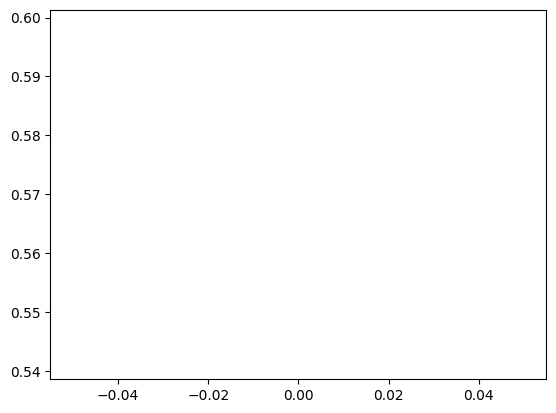

In [59]:
plt.plot(lossi)

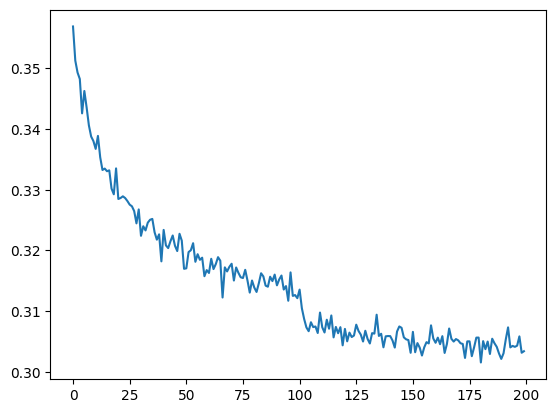

In [40]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [60]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False 

In [61]:
# evaluate the loss 
@torch.no_grad() # this decorator disables gradient tracking 
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev), 
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)  # loss function 
    print(split, loss.item())


split_loss('train')
split_loss('val')

train 3.4840917587280273
val 3.4874396324157715


In [62]:
# sample from the model 
for _ in range(20):
    out = []
    context = [0]  * block_size
    while True:
        # forward pass the neural net 
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distributions
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples 
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break 
        if ix == 0: 
            break 
    print(''.join(itos[i] for i in out))  # decode and print the generated word  

taxmiunnyolapsafdtnkviocdfs.
tgmvwkwwjbjgifengpgxypaupvfcketvguqhfxjllwbaimitviyqmno.
wvzuatzt.
txjhptzjruaqeuahadekt.
as.
hasmnbqmr.
zndcuqiaj.
qckzmpuaxblmqjifqjlh.
tavwwtevrcqpvpjzhkv.
jnzixdtjhpxzvdrkj.
txlhqcbnifjqefnwowezv.
kgneyrleoxmpw.
vjiwqhxrbugwfpqsdageyvd.
qkhfiaf.
ymhtyjnllcndetokmqz.
vozmkva.
xjlwtgfezil.
ajbalntlaveftijnlfnbyzzxb.
p.
fhxwvzajukxxaczkyebbgwkvceivpz.
